<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/fluidflow/twophasepipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculation of pressure drop in multi phase pipelines

This notebook is part of [introduction to natural gas processing using NeqSim](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb).

Litterature:
http://www.drbratland.com/

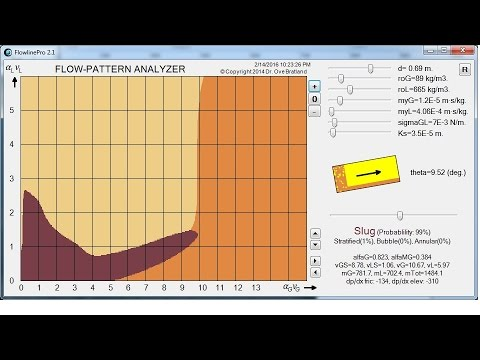

In [1]:
#@title Introduction to Calculation of pressure drop in multi phase pipelines
#@markdown Calculation of pressure drop in multi phase pipelines
from IPython.display import YouTubeVideo
YouTubeVideo('7Tsomarcq30', width=600, height=400)

In [2]:
%%capture
!pip install neqsim
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
plt.style.use('classic')
%matplotlib inline

# Demo of a simple NeqSim multi phase pipeline simulation

In [3]:
from neqsim import methods, jneqsim
from neqsim.thermo import fluid, TPflash, createfluid2,printFrame
from neqsim.process import pipe, pipeline, clearProcess, stream, runProcess

#Creating inlet fluid using SRK-EoS
names = ['methane', 'n-heptane', 'water']
molefractions = [0.8, 0.1, 0.01]
fluid1 = createfluid2(names, molefractions)
fluid1.setMultiPhaseCheck(True)
fluid1.setMixingRule('classic')

#Creating stream and pipeline
clearProcess()

stream1 = stream('stream 1', fluid1)
stream1.setFlowRate(20.0, "MSm3/day")
stream1.setTemperature(50.15, "C")
stream1.setPressure(100.0, "bara")

pipe = jneqsim.process.equipment.pipeline.PipeBeggsAndBrills('pipe 1', stream1);
pipe.setDiameter(0.710);
pipe.setPipeWallRoughness(5e-6);
pipe.setLength(100000);
pipe.setElevation(0.0);
pipe.setAngle(0);
pipe.setNumberOfIncrements(5);

runProcess()
pipe.run()

print('flow regime ', pipe.getFlowRegime())
print('pressure drop ', pipe.getPressureDrop(), ' bara')
print('outlet superficial velocity ' , pipe.getOutletSuperficialVelocity(), ' m/sec')

flow regime  INTERMITTENT
pressure drop  41.14402391525541  bara
outlet superficial velocity  9.420551726614624  m/sec


In [4]:
printFrame(stream1.getFluid())
printFrame(pipe.getOutStream().getFluid())

| 0                    | 1          | 2                 | 3                 | 4                 | 5   | 6               |
|:---------------------|:-----------|:------------------|:------------------|:------------------|:----|:----------------|
|                      | total      | GAS               | OIL               | AQUEOUS           |     |                 |
| methane              | 8.79121E-1 | 9.86375E-1        | 3.66368E-1        | 2.01975E-6        |     | [mole fraction] |
| n-heptane            | 1.0989E-1  | 1.21266E-2        | 6.32445E-1        | 8.74637E-23       |     | [mole fraction] |
| water                | 1.0989E-2  | 1.49851E-3        | 1.18645E-3        | 9.99998E-1        |     | [mole fraction] |
|                      |            |                   |                   |                   |     |                 |
| Density              |            | 7.12612E1         | 5.90128E2         | 9.79882E2         |     | kg/m3           |
| Phase Fraction       |

Text(0, 0.5, 'pressure [bara]')

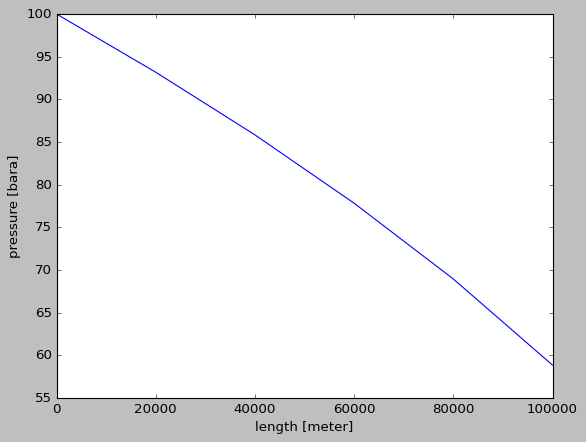

In [5]:
import matplotlib.pyplot as plt
plt.plot(pipe.getLengthProfile(), pipe.getPressureProfile())
plt.xlabel('length [meter]')
plt.ylabel('pressure [bara]')

Text(0, 0.5, 'velocity [m/sec]')

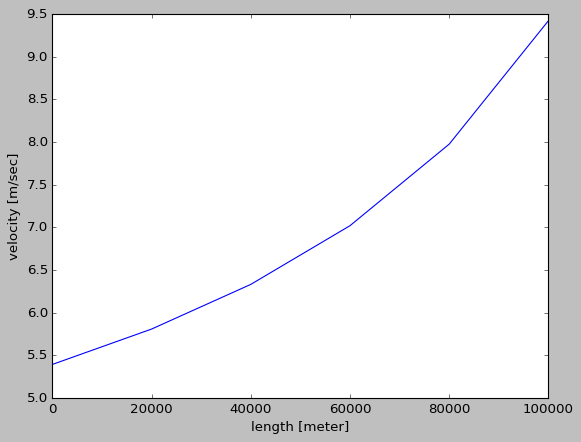

In [6]:
plt.plot(pipe.getLengthProfile(), pipe.getMixtureSuperficialVelocityProfile())
plt.xlabel('length [meter]')
plt.ylabel('velocity [m/sec]')

#Calculation of inlet pressure based on outlet pressure and flow
In the following example fwe will use the Beggs and Brill method for a multi phase pipeline.

In [7]:
from neqsim import methods
from neqsim.thermo import fluid, TPflash, createfluid2
from neqsim.process import pipe, pipeline, clearProcess, stream, runProcess
from neqsim import jneqsim
from scipy.optimize import least_squares

#Creating inlet fluid using SRK-EoS
names = ['water', 'CO2', 'nitrogen', 'methane', 'ethane', 'n-heptane']
molefractions = [0.1, 0.01, 0.01, 0.77, 0.01, 0.1]
fluid1 = createfluid2(names, molefractions)
fluid1.setMixingRule('classic')
fluid1.setMultiPhaseCheck(True)

##Defining the pipeline
diameter2 = 32*0.0254

clearProcess()

#Establish the process
stream1 = jneqsim.process.equipment.stream.Stream('stream 1', fluid1)
stream1.setFlowRate(10.0, "MSm3/day")
stream1.setTemperature(5.0, "C")
stream1.setPressure(50.0, "bara")

pipe = jneqsim.process.equipment.pipeline.PipeBeggsAndBrills('pipe 1', stream1);
pipe.setDiameter(diameter2);
pipe.setPipeWallRoughness(5e-6);
pipe.setLength(150000);
pipe.setElevation(300.0);
pipe.setNumberOfIncrements(10);

def calcinpres(inletpressure):
  stream1.setFlowRate(flow, "MSm3/day")
  stream1.setPressure(inletpressure, "bara")
  stream1.run()
  pipe.run()
  return pipe.getOutletPressure()-outletpressure


#set flow and outlet pressure to calculate inlet pressure
for flows in [0.5, 1, 2, 3, 4]:
  for outletpres in[5, 10,15]:
    outletpressure = outletpres
    flow = flows
    inletpres = least_squares(calcinpres, outletpressure+50.0, bounds = ((0.0,  np.inf)),verbose=0);
    print('inlet pressure ' ,inletpres.x, ' otlet pressure ', outletpres,  'flow ', flow, ' flow regime ', pipe.getFlowRegime())

<ipython-input-7-f7b2036f3360>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stream1.setPressure(inletpressure, "bara")


inlet pressure  [7.32508858]  otlet pressure  5 flow  0.5  flow regime  SEGREGATED
inlet pressure  [13.35839377]  otlet pressure  10 flow  0.5  flow regime  SEGREGATED
inlet pressure  [19.30726072]  otlet pressure  15 flow  0.5  flow regime  SEGREGATED
inlet pressure  [7.80166524]  otlet pressure  5 flow  1  flow regime  SEGREGATED
inlet pressure  [13.39033963]  otlet pressure  10 flow  1  flow regime  SEGREGATED
inlet pressure  [19.10888614]  otlet pressure  15 flow  1  flow regime  SEGREGATED
inlet pressure  [9.49628278]  otlet pressure  5 flow  2  flow regime  SEGREGATED
inlet pressure  [14.415462]  otlet pressure  10 flow  2  flow regime  SEGREGATED
inlet pressure  [19.6730204]  otlet pressure  15 flow  2  flow regime  SEGREGATED
inlet pressure  [12.24277479]  otlet pressure  5 flow  3  flow regime  SEGREGATED
inlet pressure  [15.72181332]  otlet pressure  10 flow  3  flow regime  SEGREGATED
inlet pressure  [20.84860641]  otlet pressure  15 flow  3  flow regime  SEGREGATED
inlet pr

In [8]:
#Establish the process
fluid1.setMultiPhaseCheck(True)
stream1 = jneqsim.process.equipment.stream.Stream('stream 1', fluid1)
stream1.setFlowRate(4.0, "MSm3/day")
stream1.setTemperature(5.0, "C")
stream1.setPressure(22.24586, "bara")
stream1.run()

pipe = jneqsim.process.equipment.pipeline.PipeBeggsAndBrills('pipe 1', stream1);
pipe.setDiameter(diameter2);
pipe.setPipeWallRoughness(5e-6);
pipe.setLength(150000);
pipe.setElevation(300.0);
pipe.setNumberOfIncrements(20);
stream1.run()
pipe.run()


print('outlet pressure ', pipe.getOutletPressure(), ' flow regime ', pipe.getFlowRegime())

outlet pressure  15.26023001811174  flow regime  SEGREGATED


#Estimating inlet pressure based on flow and outlet pressure
In the following example we will use the above method to calculate to inlet pressure based on a known outlet pressure and flow rate.

In [9]:
#Creating inlet fluid using SRK-EoS
from neqsim.process import mixer

GOR = 1000.0
WC = 0.4

names = ['methane', 'nC20', 'water']
molefractions =  [0.3, 0.3, 0.3]
fluid1 = createfluid2(names, molefractions)
fluid1.setMixingRule('classic')
fluid1.setMultiPhaseCheck(True)
fluid1.setTemperature(15.0, 'C')
fluid1.setPressure(1.01325, 'bara')
fluid1.initProperties()

clearProcess()

gas_stream = stream('stream 1', fluid1.clone())
gas_stream.getFluid().setMolarComposition([1.0, 0.0, 0.0])
gas_stream.setFlowRate(GOR, 'Sm3/hr')
gas_stream.run()

oil_stream = stream('stream 2', fluid1.clone())
oil_stream.getFluid().setMolarComposition([0.0, 1.0, 0.0])
oil_stream.setFlowRate(1.0, 'idSm3/hr')
oil_stream.run()

water_stream = stream('stream 3', fluid1.clone())
water_stream.getFluid().setMolarComposition([0.0, 0.0, 1.0])
water_stream.setFlowRate(WC/(1.0-WC), 'idSm3/hr')
water_stream.run()

mixer1 = mixer('mixer 1')
mixer1.addStream(gas_stream)
mixer1.addStream(oil_stream)
mixer1.addStream(water_stream)
mixer1.run()

fluid1 = mixer1.getFluid()
TPflash(fluid1)
printFrame(fluid1)
fluid1.initProperties()
GOR_calc = gas_stream.getFlowRate('Sm3/hr')/oil_stream.getFlowRate('m3/hr')
WC_calc = fluid1.getPhase('aqueous').getVolume('m3')/(fluid1.getPhase('oil').getVolume('m3')+fluid1.getPhase('aqueous').getVolume('m3'))
print('GOR ', GOR_calc, ' [-]')
print('water cut ', WC_calc, ' [-]')

| 0                    | 1          | 2                  | 3                  | 4                  | 5   | 6               |
|:---------------------|:-----------|:-------------------|:-------------------|:-------------------|:----|:----------------|
|                      | total      | GAS                | OIL                | AQUEOUS            |     |                 |
| methane              | 5.15445E-1 | 9.90365E-1         | 7.16431E-3         | 2.53179E-9         |     | [mole fraction] |
| nC20                 | 3.39882E-2 | 3.76323E-9         | 9.84814E-1         | 2.25632E-59        |     | [mole fraction] |
| water                | 4.50566E-1 | 9.63461E-3         | 8.02125E-3         | 1E0                |     | [mole fraction] |
|                      |            |                    |                    |                    |     |                 |
| Density              |            | 6.8835E-1          | 8.56696E2          | 1.01372E3          |     | kg/m3           |


<ipython-input-10-2c23e78cd7de>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  feed_stream.setPressure(inletpressure, "bara")


failed to solve....
failed to solve....
failed to solve....
failed to solve....
failed to solve....
failed to solve....
failed to solve....


,flow,in_pressure,out_pressure,flowregime,velocity
0,0.5,22.112590,20.0,"(S, E, G, R, E, G, A, T, E, D)",1.963211
1,0.5,60.737599,60.0,"(T, R, A, N, S, I, T, I, O, N)",0.717614
2,0.5,90.503072,90.0,"(T, R, A, N, S, I, T, I, O, N)",0.490711
3,0.5,120.367250,120.0,"(T, R, A, N, S, I, T, I, O, N)",0.383152
4,0.5,150.272430,150.0,"(T, R, A, N, S, I, T, I, O, N)",0.324693
...,...,...,...,...,...
114,15.0,840.000000,90.0,"(I, N, T, E, R, M, I, T, T, E, N, T)",5.927533
115,15.0,870.000415,120.0,"(I, N, T, E, R, M, I, T, T, E, N, T)",5.901711
116,15.0,899.999341,150.0,"(I, N, T, E, R, M, I, T, T, E, N, T)",5.877118
117,15.0,930.768026,180.0,"(I, N, T, E, R, M, I, T, T, E, N, T)",5.853071


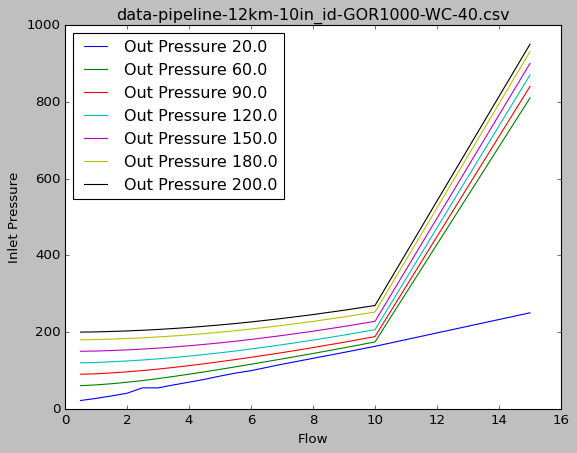

In [10]:
from neqsim.thermo import fluid, TPflash, createfluid2
from neqsim.process import pipe, pipeline, clearProcess, stream, runProcess
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import random

pipe_wall_roughness = 15e-6 #meter
pipeline_length = 12 #km
pipeline_diameter = 10 #inches
elevation = 0.0 #meter

feed_stream = jneqsim.process.equipment.stream.Stream('stream 1', fluid1)
feed_stream.setTemperature(5.0, 'C')
feed_stream.setPressure(100.0, 'bara')
pipeline = jneqsim.process.equipment.pipeline.PipeBeggsAndBrills('pipe 1', feed_stream)
pipeline.setPipeWallRoughness(pipe_wall_roughness)
pipeline.setLength(pipeline_length*1e3)
pipeline.setElevation(elevation)
pipeline.setDiameter(pipeline_diameter*0.0254)
pipeline.setNumberOfIncrements(20)

def calcinpres(inletpressure, flow, outletpressure):
  feed_stream.setFlowRate(flow, "MSm3/day")
  feed_stream.setPressure(inletpressure, "bara")
  feed_stream.run()
  try:
    pipeline.run()
  except:
    return random.uniform(200, 1000)
  return pipeline.getOutletStream().getPressure("bara") - outletpressure

data = {'flow': [],  'in_pressure':[], 'out_pressure': [],  'flowregime':[],'velocity':[] }

#set flow and outlet pressure to calculate inlet pressure
for flows in [0.5, 1, 1.5, 2, 2.5,  3, 3.5,  4, 4.5, 5, 5.5, 6, 7, 8, 9, 10, 15]:
  for outletpres in[20, 60, 90.0, 120, 150, 180.0, 200.0]:
    data['flow'].append(flows)
    data['out_pressure'].append(outletpres)
    inletpres = least_squares(calcinpres, outletpres+flows*50, args=(flows, outletpres), bounds=(5.0, 5000.0))
    if(inletpres.fun > 1):
      print('failed to solve....')
    data['in_pressure'].append(inletpres.x[0]);
    data['flowregime'].append(pipeline.getFlowRegime())
    data['velocity'].append(pipeline.getInletSuperficialVelocity());

list = pipeline.getFlowRegimeProfile()

df = pd.DataFrame(data)
filename = 'data-pipeline-'+ str(pipeline_length) + 'km-' + str(pipeline_diameter) + 'in_id-GOR' + str(int(GOR))+ '-WC-' + str(int(WC*100))+ '.csv'
df.to_csv(filename)

from IPython.display import display
display(df)

grouped = df.groupby('out_pressure')

# Create line plots for each group
fig, ax = plt.subplots()
for name, group in grouped:
    ax.plot(group['flow'],group['in_pressure'], label='Out Pressure {}'.format(name))
ax.set_ylabel('Inlet Pressure')
ax.set_xlabel('Flow')
ax.legend(loc='best')
plt.title(filename)
plt.show()